In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [49]:
#train function
def trainFunc(model,num_epochs,train_batch_size):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            # Forward pass
            prediction = model(images.view(-1,784))
            loss = loss_func(prediction, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            if (i+1) % 10 == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                # train_epoch.append(epoch)
                # print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %')
                # train_acc.append(acc)
                if epoch == num_epochs:
                        print("Max Epoch Reached")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False
                        
    return train_epoch,train_losses,train_acc

In [7]:
import copy

In [8]:
batchArr = np.linspace (10,1510,5)
print(batchArr)

[  10.  385.  760. 1135. 1510.]


In [50]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images.view(-1,784))
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
    netTest_loss = testLoss/n_samples
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1} & Test Loss: {netTest_loss} %')
    return netTest_acc1, netTest_loss

In [18]:
#Calculation for sensitivity
def sensitivityFunc(model):
    
    froGrad=0
    count =0 
    sensitivity=[]
  
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            froGrad_norm = torch.linalg.norm(grad).numpy()
            froGrad += froGrad_norm
            count += 1
       
    sensitivity.append(froGrad/count)
    return sensitivity
        
    

In [37]:
modelsTrainEpochArr = []
modelsTrainLossArr = []
modelsTrainAccArr = []
modelsTestLossArr = []
modelsTestAccArr = []
modelsSensitivityArr=[]

for i in range (len(batchArr)):
    j=copy.deepcopy(i) 
    j = Model()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=1e-3) #weight_decay = weight_decay_val)

    max_epochs = 15
    train_batch_size = int(batchArr[i])

    a=[]
    for k in j.parameters():
        a.append(torch.numel(k))
    print(f'Total no of parameters in Model :{np.sum(a)} for with batch size:{train_batch_size}')

    train_epoch,train_losses,train_acc = trainFunc(j,max_epochs,train_batch_size)

    test_batch_size = int(batchArr[i])

    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    sensitivity = sensitivityFunc(j)
    
    modelsTrainEpochArr.append(train_epoch)
    modelsTrainLossArr.append(train_losses)
    modelsTrainAccArr.append(train_acc)
    modelsTestAccArr.append(testAcc)
    modelsTestLossArr.append(testLoss)
    modelsSensitivityArr.append(sensitivity)

Total no of parameters in Model :84060 for with batch size:10
strated
Train O/P: Epoch [1/15], Step [10/6000], Loss: 2.3075
Train O/P: Epoch [1/15], Step [20/6000], Loss: 2.0573
Train O/P: Epoch [1/15], Step [30/6000], Loss: 1.8073
Train O/P: Epoch [1/15], Step [40/6000], Loss: 1.9607
Train O/P: Epoch [1/15], Step [50/6000], Loss: 1.8424
Train O/P: Epoch [1/15], Step [60/6000], Loss: 1.1642
Train O/P: Epoch [1/15], Step [70/6000], Loss: 0.9997
Train O/P: Epoch [1/15], Step [80/6000], Loss: 1.5916
Train O/P: Epoch [1/15], Step [90/6000], Loss: 0.4419
Train O/P: Epoch [1/15], Step [100/6000], Loss: 0.8294
Train O/P: Epoch [1/15], Step [110/6000], Loss: 0.6236
Train O/P: Epoch [1/15], Step [120/6000], Loss: 0.3525
Train O/P: Epoch [1/15], Step [130/6000], Loss: 0.2729
Train O/P: Epoch [1/15], Step [140/6000], Loss: 1.1639
Train O/P: Epoch [1/15], Step [150/6000], Loss: 0.8983
Train O/P: Epoch [1/15], Step [160/6000], Loss: 0.6493
Train O/P: Epoch [1/15], Step [170/6000], Loss: 0.7810
Trai

In [38]:
len(modelsTrainAccArr)

5

In [39]:
modelsTestAccArr

[97.57, 97.42, 97.12, 96.85, 96.53]

In [40]:
def meanScore(dataArr):
    meanModelData = []
    for i in range (len(dataArr)):
        meanScore = np.mean(dataArr[i])
        meanModelData.append(meanScore)
    return meanModelData

def minScore(dataArr):
    minModelScore = []
    for i in range (len(dataArr)):
        minScore = np.mean(dataArr[i])
        minModelScore.append(minScore)
    return minModelScore

def maxScore(dataArr):
    maxModelScore = []
    for i in range (len(dataArr)):
        maxScore = np.max(dataArr[i])
        maxModelScore.append(maxScore)
    return maxModelScore


In [41]:
print(minScore(modelsTrainLossArr))

[0.07490794952518706, 0.15160984105916106, 0.21239186806706437, 0.25291567122880015, 0.2856511481354634]


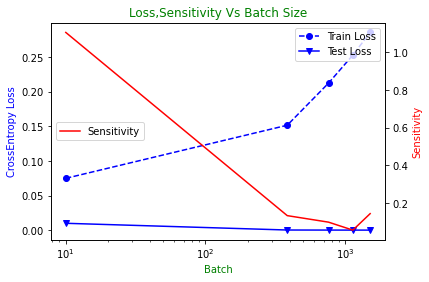

In [46]:
fig,ax=plt.subplots()
ax.plot(batchArr,minScore(modelsTrainLossArr),color="Blue", marker="o",linestyle='dashed')
ax.plot(batchArr,modelsTestLossArr,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="upper right")
ax.set_xlabel("Batch",color="Green")
ax.set_xscale('log')
ax.set_ylabel("CrossEntropy Loss",color = "blue")
ax.set_title("Loss,Sensitivity Vs Batch Size",color="g")

ax2=ax.twinx()
ax2.plot(batchArr,modelsSensitivityArr,color="red")
ax2.set_xlabel("Batch",color="Green")
ax2.set_ylabel("Sensitivity",color = "red")
ax2.legend(['Sensitivity'],loc="center left")

plt.show()
fig.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/Diff Batch Graph HW1_3.2Loss.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

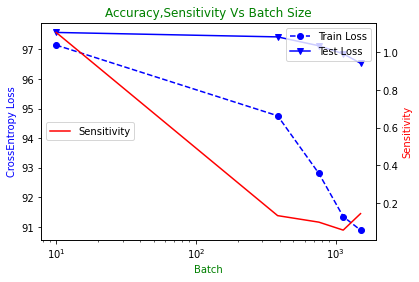

In [47]:
fig,ax=plt.subplots()
ax.plot(batchArr,minScore(modelsTrainAccArr),color="Blue", marker="o",linestyle='dashed')
ax.plot(batchArr,modelsTestAccArr,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="upper right")
ax.set_xlabel("Batch",color="Green")
ax.set_xscale('log')
ax.set_ylabel("CrossEntropy Loss",color = "blue")
ax.set_title("Accuracy,Sensitivity Vs Batch Size",color="g")

ax2=ax.twinx()
ax2.plot(batchArr,modelsSensitivityArr,color="red")
ax2.set_xlabel("Batch",color="Green")
ax2.set_ylabel("Sensitivity",color = "red")
ax2.legend(['Sensitivity'],loc="center left")

plt.show()
fig.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/Diff Batch Graph HW1_3.2Acc.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')